### Group Assignment
### Team Number: 3
### Team Member Names: Derek Tan, Jeff Peng, Yuqian Lin
### Team Strategy Chosen: SAFE

### Abstract

Our portfolio optimization strategy involves the use and implementation of the Modern Portfolio Theory (MPT) and analysis of the Efficient Frontier graphs. The objective of the portfolio optimization strategy is to maximize the portfolio return while maintaining the minimum portfolio risk. 

Modern Portfolio Theory states that since it is assumed that all investors are risk-adverse, when considering the possible portfolio allocation strategies, the investor will prefer the portfolio that maximizes the possible return while maintaining a given amount of risk. 

The Efficient Frontier (EF), the core of our strategy, was introduced by Nobel Laureate Harry Markowitz and is fundamental to MPT. The EP is a graph that illustrates all possible portfolios portfolio allocation distributions. The x-axis represents the volatility/risk of the portfolio, while the y-axis represents the expected return of the portfolio.

The Efficient Frontier shows the optimized portfolios that offer the highest expected return for a given level of risk and the lowest level of risk for a given level of expected return.

An example of the an Efficient Frontier graph is shown below:

![EF Graph](ef.png)

As seen from the graph, the light blue dot is the portfolio that takes on the highest level of risk coupled with the highest degree of return. Conversely, the left-most purple dot depicts the portfolio that with the lowest level of risk and lowest given level of return. Typically, risk-seeking investors will select portfolios that lie on the right end as they yield a higher return for a high level of risk. In our group's case, we chose the "safe" strategy, and thus will be selecting the portfolio on the left-end of the graph as it yields a lower return for a lower level of risk.

We will be discussing more about how we graphed each portfolio along the EF graph below.

In [1]:
from IPython.display import display, Math, Latex
from datetime import datetime

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt

Before implementing our strategy, we have to filter out any invalid stock tickers. That is, any tickers that are not traded in USD and tickers with an average daily volume of less than 10000 shares.

In [2]:
# Filter list of tickers for valid tickers

# filter_tickers(list_of_tickers) produces a list of tickers
#   of all tickers in [list_of_tickers] that have a daily 
#   average volume above 10 000 shares and are traded in USD

"""
Params:
    list_of_tickers (listof Str): Unfiltered original list of tickers
"""

def filter_tickers(list_of_tickers):
    valid_tickers = []
    
    start_date = "2021-07-02"
    end_date = "2021-10-22"

    for i in range(len(list_of_tickers)):
        ticker = yf.Ticker(list_of_tickers[i])
        ticker_hist = ticker.history(start=start_date, end=end_date)

        if ticker_hist["Volume"].mean() >= 10000 or ticker.info["currency"] == "USD":
            valid_tickers.append(list_of_tickers[i])

    return valid_tickers

In [3]:
def filters_nan(ticker_list):
    start_date = "2018-01-02"
    end_date = "2021-10-31"
    no_nan = []
    
    for i in range (ticker_list.shape[1]):
        if ticker_list.iloc[:, i].isna().sum() <= 1:
            no_nan.append((ticker_list.columns)[i])
        
    data=yf.download(no_nan, start=start_date, end=end_date)
    return data['Adj Close']

In [4]:
# Import Financial Data

# tickers = pd.read_csv("Tickers.csv", index_col=False)

start_date = "2018-01-02"
end_date = "2021-10-31"


# Testing on S&P 500 Tickers
# wiki_page = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

# Removed BF.B and BRK.B since they are delisted and obsolete
# list_of_tickers1 = wiki_page[0].Symbol.values.tolist()

# list_of_tickers.remove('BF.B')
# list_of_tickers.remove('BRK.B')

list_of_tickers1 = ["CSCO", "TGT", "BK", "MRK", "PFE", "COP", "LLY", "CL", "GOOG", "COF"]
list_of_tickers = filter_tickers(list_of_tickers1)

data = yf.download(list_of_tickers, start=start_date, end=end_date)

unfiltered_CP=data['Adj Close']
closing_prices = filters_nan(unfiltered_CP)

#This list of valid tickers will be used later when generating the portfolio
tickers = closing_prices.columns
# unfiltered_CP.iloc[:, 1].isna().sum()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


To compare price fluctuations, we will calculate the daily percentage change in the price of each stock. By calculating percent change, it makes it easier to compare price fluctuations between stocks as their price changes will all be with respect to the same ratio, that is a percentage.

**The stuff in red is what Derek wrote. We can keep it for now and see what to get rid of later**

<span style = "color: red">To compare the price fluctuations, we will calculate the daily percent change in the price of each stock. This way, it makes the price fluctuations easier to compare, as the price of the stock itself becomes removed from the equation, and we only consider the magnitude of the price movements in comparison to the stock price.* </span>

In [5]:
# Calculate percent change

percent_change = closing_prices.pct_change().apply(lambda x: np.log(1+x))

percent_change.head()

,BK,CL,COF,COP,CSCO,GOOG,LLY,MRK,PFE,TGT
Date,,,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.006113,-0.003867,-0.001708,0.018270,0.007946,0.016280,0.005418,-0.001424,0.007382,-0.006825
2018-01-04,0.009923,0.006392,0.019716,0.011471,0.002825,0.003615,0.004453,0.016080,0.002177,-0.019847
2018-01-05,0.002557,0.001194,0.000099,-0.001932,0.013754,0.014466,0.012203,-0.001052,0.001901,0.010574
2018-01-08,0.004186,0.001458,-0.006231,0.010145,0.010319,0.004264,-0.005095,-0.005807,-0.011186,0.009422


### Constructing the Efficient Frontier Graph
To construct an Efficient Frontier Graph, we require three factors:
- Covariance of the securities in the portfolio
- Standard deviation also known as risk
- The expected return of the portfolio

Below, we will be calculating all these three factors.

#### Covariance

We will now analyze the covariance of each stock in relation to one another. The covariance of two stocks (stock X, stock Y) is calculated using the following equation:

\begin{align*}
COV(X,Y)=\frac{\sum(x_i-\overline{X})\times(y_i-\overline{Y})}{N}
\end{align*}

We will store the results of the covariance calculations in 'cov_matrix'.

In [6]:
cov_matrix = percent_change.cov()

cov_matrix

,BK,CL,COF,COP,CSCO,GOOG,LLY,MRK,PFE,TGT
BK,0.000417,0.000095,0.000404,0.000355,0.000200,0.000171,0.000116,0.000127,0.000138,0.000133
CL,0.000095,0.000193,0.000122,0.000104,0.000119,0.000104,0.000110,0.000100,0.000095,0.000096
COF,0.000404,0.000122,0.000764,0.000514,0.000259,0.000241,0.000127,0.000157,0.000168,0.000174
COP,0.000355,0.000104,0.000514,0.000840,0.000255,0.000238,0.000149,0.000151,0.000148,0.000152
CSCO,0.000200,0.000119,0.000259,0.000255,0.000345,0.000206,0.000155,0.000134,0.000151,0.000151
GOOG,0.000171,0.000104,0.000241,0.000238,0.000206,0.000345,0.000130,0.000113,0.000120,0.000120
LLY,0.000116,0.000110,0.000127,0.000149,0.000155,0.000130,0.000360,0.000150,0.000160,0.000113
MRK,0.000127,0.000100,0.000157,0.000151,0.000134,0.000113,0.000150,0.000219,0.000140,0.000092
PFE,0.000138,0.000095,0.000168,0.000148,0.000151,0.000120,0.000160,0.000140,0.000242,0.000094
TGT,0.000133,0.000096,0.000174,0.000152,0.000151,0.000120,0.000113,0.000092,0.000094,0.000378


#### Standard Deviation

To calculate standard deviation, we need to calculate the correlation between stocks.

To do this, we will use a correlation matrix.

The correlation of two stocks (stock X, stock Y) is calculated using the following equation:

\begin{align*}
\rho(X,Y)=\frac{COV(X,Y)}{\sigma_X \sigma_Y}
\end{align*}

Where $\rho_{x,y}$ is the correlation between the two variables, $cov(r_x, r_y)$ is the covariance of return X and return Y, and $\sigma_x$ and $\sigma_y$ are the standard deviations of X and Y respectively.

Note that each stock has a correlation of 1 with itself, a perfect positive correlation.

There exists a positive correlation between stocks X and Y if $0 < \rho_{x,y} < 1$.

There exists a negative (inverse) correlation between stocks X and Y if $-1 < \rho_{x,y} < 0$.

There exists no (zero) correlation between stocks X and Y if $\rho_{x,y} = 0$. In reality, it is almost impossible for two stocks to have zero correlation with each other.

We will store the results of the correlation calculations in 'corr_matrix'.

In [7]:
corr_matrix = percent_change.corr()

corr_matrix

,BK,CL,COF,COP,CSCO,GOOG,LLY,MRK,PFE,TGT
BK,1.000000,0.333690,0.715997,0.599891,0.528991,0.452035,0.299603,0.421078,0.435655,0.336288
CL,0.333690,1.000000,0.318424,0.259415,0.460421,0.404164,0.419310,0.484882,0.438185,0.356295
COF,0.715997,0.318424,1.000000,0.641596,0.503969,0.468597,0.242755,0.385147,0.390804,0.322902
COP,0.599891,0.259415,0.641596,1.000000,0.474677,0.441667,0.271160,0.352710,0.329133,0.269761
CSCO,0.528991,0.460421,0.503969,0.474677,1.000000,0.598118,0.441088,0.488685,0.520996,0.416974
GOOG,0.452035,0.404164,0.468597,0.441667,0.598118,1.000000,0.368270,0.410805,0.414551,0.331866
LLY,0.299603,0.419310,0.242755,0.271160,0.441088,0.368270,1.000000,0.534484,0.541516,0.306423
MRK,0.421078,0.484882,0.385147,0.352710,0.488685,0.410805,0.534484,1.000000,0.607066,0.318520
PFE,0.435655,0.438185,0.390804,0.329133,0.520996,0.414551,0.541516,0.607066,1.000000,0.311788
TGT,0.336288,0.356295,0.322902,0.269761,0.416974,0.331866,0.306423,0.318520,0.311788,1.000000


#### Expected Return
Finally, we will calculate the expected return of each portfolio. The expected return of a portfolio is caluclated by the equation below:

\begin{align*}
E(X)=\overline{X}=\frac{\sum x_i}{N}
\end{align*}

where $x_i$ are individual returns of some security $X$, $N$ is the total number of observations (time periods for us)

In [8]:
closing_prices.resample('Y').first()

,BK,CL,COF,COP,CSCO,GOOG,LLY,MRK,PFE,TGT
Date,,,,,,,,,,
2018-12-31,48.540569,68.314117,93.266151,49.569439,34.448795,1065.000000,78.010109,47.838718,29.758003,61.324654
2019-12-31,43.703491,55.179958,73.602325,57.810555,39.231712,1045.849976,108.490967,66.292542,36.581047,62.257931
2020-12-31,48.002949,65.051903,100.498848,61.042171,45.812050,1367.369995,127.675949,82.918121,34.333920,121.897720
2021-12-31,40.592579,82.446381,96.174301,38.381344,43.054035,1728.239990,163.029160,75.252045,35.423965,175.223892


In [9]:
# Calculate Yearly Expected Returns (Returns)

individual_expected_returns = closing_prices.resample('Y').first().pct_change().mean()

yearly_stats = pd.DataFrame(individual_expected_returns, columns=['Returns'])

# Calculate Annual Standard Deviation (Volatility)

trading_days = 250

annual_standard_deviation = percent_change.std().apply(lambda x: x * np.sqrt(trading_days))

yearly_stats['Volatility'] = annual_standard_deviation

yearly_stats

,Returns,Volatility
BK,-0.051882,0.322761
CL,0.084679,0.219588
COF,0.037188,0.437067
COP,-0.049693,0.458348
CSCO,0.082123,0.293571
GOOG,0.184453,0.293741
LLY,0.281487,0.299857
MRK,0.181363,0.233781
PFE,0.066535,0.246057
TGT,0.470211,0.307390


In [10]:
# Change this number to change the number of randomly generated portfolios
# The more number of random portfolios generated, the more optimized
#   the final optimized portfolio will be

number_of_portfolios = 1000

In [11]:
# Generate portfolios with random weights

# generate_portfolios(tickers, number_of_portfolios) generates
#   a collection of [number_of_portfolios] portfolios from the
#   list of [tickers]

"""
Params:
    tickers (listof Str): List of stock tickers to choose from
    number_of_portfolios (Nat): Number of portfolios to generate
"""


def generate_portfolios(tickers, number_of_portfolios):
    weights = []
    returns = []
    volatility = []

    for i in range(number_of_portfolios):
        individual_weights = np.random.random(len(tickers))
        individual_weights = individual_weights / np.sum(individual_weights)
        weights.append(individual_weights)

        individual_returns = np.dot(individual_weights, yearly_stats.Returns)
        returns.append(individual_returns)

        portfolio_variance = (
            cov_matrix.mul(individual_weights, axis=0)
            .mul(individual_weights, axis=1)
            .sum()
            .sum()
        )
        standard_deviation = np.sqrt(portfolio_variance)
        individual_volatility = standard_deviation * np.sqrt(trading_days)
        volatility.append(individual_volatility)
        
    portfolios = pd.DataFrame(index=range(number_of_portfolios))
    
    portfolios['Returns'] = returns
    portfolios['Volatility'] = volatility
    
#     for i in range(number_of_tickers):
#         portfolios[tickers[i]] = weights[i]
    
    return portfolios


random_portfolios = generate_portfolios(tickers, number_of_portfolios)

random_portfolios.head()

,Returns,Volatility
0,0.118605,0.216658
1,0.138752,0.230873
2,0.165884,0.243360
3,0.145234,0.218689
4,0.108971,0.215181


In [12]:
# Pick optimal portfolio

safest_portfolio = random_portfolios.iloc[random_portfolios.Volatility.idxmin()]

safest_portfolio

Returns       0.169216
Volatility    0.192421
Name: 960, dtype: float64

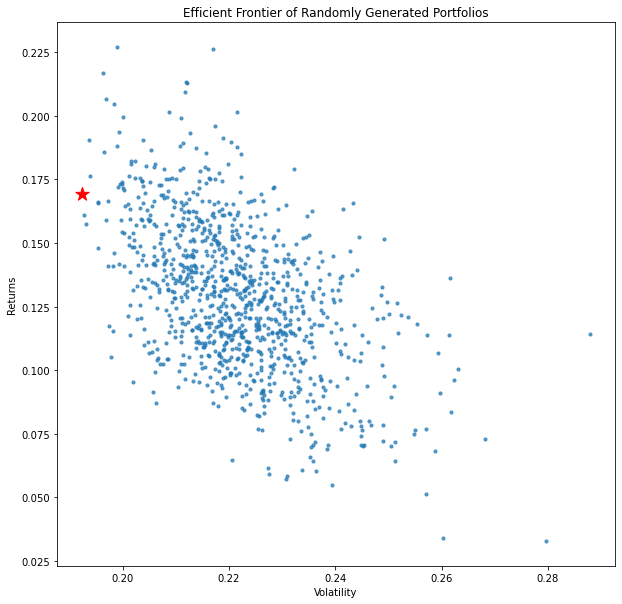

In [13]:
# Plot Efficient Frontier Graph

plt.subplots(figsize=[10, 10])

plt.scatter(x=random_portfolios.Volatility, y=random_portfolios.Returns, s=10, alpha=0.7)

plt.scatter(safest_portfolio.Volatility, safest_portfolio.Returns, color='r', marker='*', s=200)

plt.title("Efficient Frontier of Randomly Generated Portfolios")
plt.xlabel("Volatility")
plt.ylabel("Returns")

plt.show()

In [14]:
# Rebalance optimal portfolio to top 20 stocks

In [15]:
# Produce final list of chosen tickers and weights

In [16]:
# Function Unit Testing using unittest

import unittest

# Work in Progress

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Derek, Yuqian, Jeff

### Sources

*I will make this look nicer later*

Image Link: https://www.cryptimi.com/guides/is-diversification-the-right-strategy-for-your-cryptocurrency-portfolio

Equations: Professor Thompson's notes


Definition of MPT & EF: https://www.investopedia.com/terms/e/efficientfrontier.asp https://www.investopedia.com/terms/m/modernportfoliotheory.asp
